# Обработка информации об уязвимостях полученных из Github advisory (https://github.com/advisories)


In [1]:
from git import Repo
from typing import Any
from pathlib import Path
import seaborn as sns
import polars as pl
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import orjson

## Загрузка данных

In [ ]:
Repo.clone_from("git@github.com:github/advisory-database.git", "advisory-database")

In [2]:
vulnerabilities_data: list[dict[str, Any]] = []

with ThreadPoolExecutor(20) as p:
    for content in p.map(lambda fp: fp.read_text(), Path("advisory-database").rglob("*.json")):
        vulnerability_data = orjson.loads(content)
        cve_ids: list[str] = []
        for alias in vulnerability_data["aliases"]:
            if alias.startswith("CVE-"):
                cve_ids.append(alias[4:])
        references: list[str] = []
        for reference in vulnerability_data["references"]:
            if reference["type"] in {"WEB", "PACKAGE"}:
                references.append(reference["url"])
        cwes: list[str] = vulnerability_data["database_specific"]["cwe_ids"]
        vulnerabilities_data.append({"cve_id": cve_ids, "reference": references, "cwe_id": cwes})

len(vulnerabilities_data)

219969

## Обработка данных

In [3]:
vulnerabilities: pl.DataFrame = pl.DataFrame(vulnerabilities_data)
vulnerabilities = vulnerabilities.explode("cve_id").explode("reference").explode("cwe_id")
vulnerabilities.describe()

describe,cve_id,reference,cwe_id
str,str,str,str
"""count""","""890748""","""890748""","""890748"""
"""null_count""","""4394""","""272""","""354098"""
"""mean""",null,null,null
"""std""",null,null,null
"""min""","""1999-0001""","""://github.com/…","""CWE-1004"""
"""25%""",null,null,null
"""50%""",null,null,null
"""75%""",null,null,null
"""max""","""2024-0070""","""www.github.com…","""CWE-99"""


In [4]:
Path("results").mkdir(exist_ok=True)
vulnerabilities.write_csv("results/github_cves.csv")

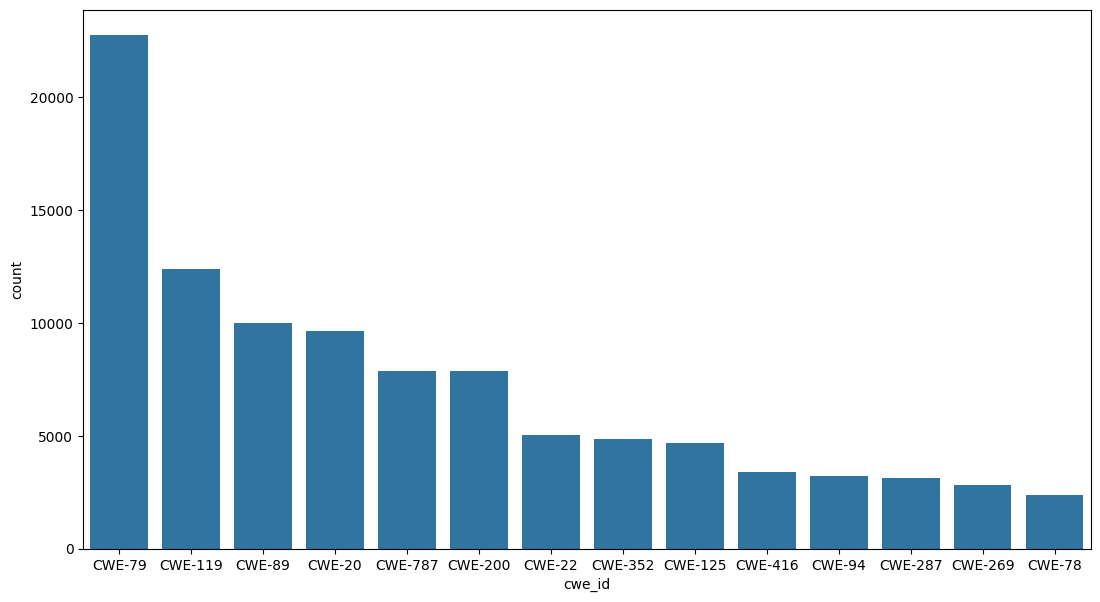

In [5]:
fig, ax = plt.subplots(figsize=(13, 7))
top_vulnerabilities = (
    vulnerabilities.unique(["cwe_id", "cve_id"]).group_by("cwe_id").count().sort("count", descending=True).limit(15)
)
top_ids = top_vulnerabilities.select("cwe_id").to_series().to_list()
sns.barplot(top_vulnerabilities, x="cwe_id", y="count", ax=ax)
plt.show()